In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 10
EPOCHS_FINE_TUNE = 5
DATASET_DIR = '/content/drive/MyDrive/Bangladeshi_Currency_Recognizer/archive/Bangladesh_Money_note'

In [4]:
# --- DATA PREPARATION ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1313 images belonging to 11 classes.
Found 323 images belonging to 11 classes.
Found 0 images belonging to 0 classes.


In [5]:
# --- BASE MODEL ---
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# --- CUSTOM HEAD ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# --- COMPILE INITIAL MODEL ---
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# --- TRAIN TOP LAYERS ---
history = model.fit(
    train_generator,
    epochs=EPOCHS_INITIAL,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.1209 - loss: 4.9562 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 1049s 25s/step - accuracy: 0.1217 - loss: 4.9399 - val_accuracy: 0.3715 - val_loss: 1.7776
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 983s 24s/step - accuracy: 0.2819 - loss: 2.9297 - val_accuracy: 0.6254 - val_loss: 1.1736
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1019s 24s/step - accuracy: 0.4125 - loss: 2.1388 - val_accuracy: 0.6811 - val_loss: 0.8907
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1041s 24s/step - accuracy: 0.5495 - loss: 1.4253 - val_accuracy: 0.7678 - val_loss: 0.6992
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1015s 24s/step - accuracy: 0.6029 - loss: 1.1876 - val_accuracy: 0.8173 - val_loss: 0.5890
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1004s 24s/step - accuracy: 0.6564 - loss: 1.0405 - val_accuracy: 0.8607 - val_loss: 0.5169
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1005s 24s/step - accuracy: 0.7576 - loss: 0.7443 - val_accuracy: 0.8793 - val_loss: 0.4520
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1007s 24s/step - accuracy: 0.7766 - loss: 0.7037 - val_accuracy: 0.9009

In [7]:
# --- FINE-TUNING ---
# Unfreeze last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with lower LR
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=val_generator
)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1194s 28s/step - accuracy: 0.8609 - loss: 0.4050 - val_accuracy: 0.9567 - val_loss: 0.1525
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1184s 28s/step - accuracy: 0.9538 - loss: 0.1610 - val_accuracy: 0.9752 - val_loss: 0.0839
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1186s 29s/step - accuracy: 0.9717 - loss: 0.1149 - val_accuracy: 0.9690 - val_loss: 0.0876
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1243s 30s/step - accuracy: 0.9778 - loss: 0.0787 - val_accuracy: 0.9752 - val_loss: 0.0754
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1230s 28s/step - accuracy: 0.9867 - loss: 0.0671 - val_accuracy: 0.9814 - val_loss: 0.0515


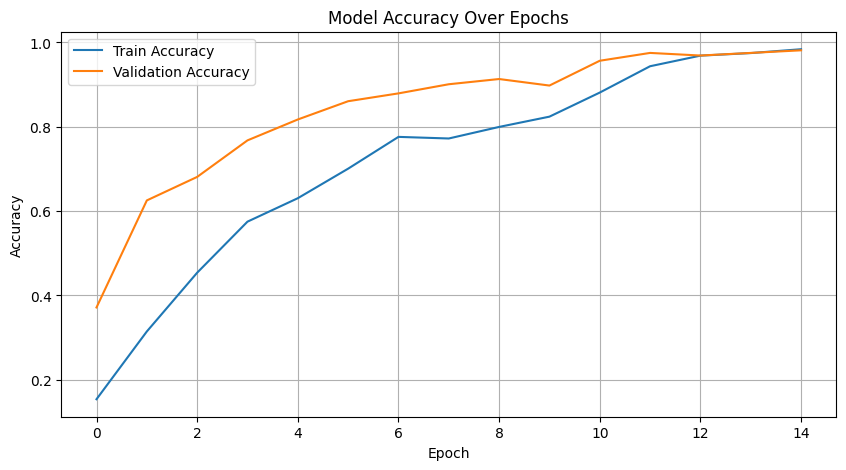

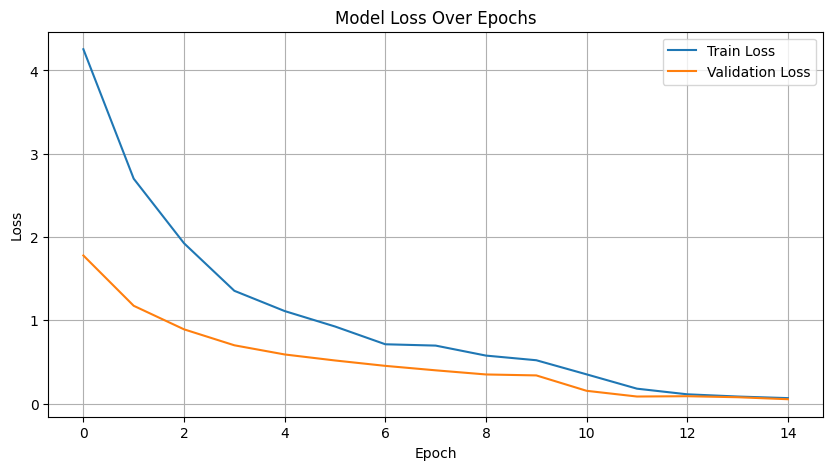

In [14]:
# --- Combine histories from initial training and fine-tuning ---
def combine_history(h1, h2):
    history = {}
    for key in h1.history.keys():
        history[key] = h1.history[key] + h2.history[key]
    return history

combined_history = combine_history(history, history_finetune)

# --- Plotting Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Plotting Loss ---
plt.figure(figsize=(10, 5))
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
model.save("bdt_currency_model_vgg16_finetuned.h5")
